In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Classification with TItanic dataset
- Data from Kaggle's Titanic competition: [data dictionary](https://www.kaggle.com/c/titanic/data)
- **Goal**: Predict survival based on passenger characteristics
- `titanic.csv` is already in our repo, so there is no need to download the data from the Kaggle website

In [2]:
data_file = 'data/titanic.csv'
titanic = pd.read_csv(data_file, index_col='PassengerId')
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


### Embarked 변수 처리

In [4]:
titanic['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [5]:
embark_dum = pd.get_dummies(titanic['Embarked'], prefix='port')
embark_dum.drop(embark_dum.columns[2], axis=1, inplace=True)
embark_dum.sample(n = 10)

,port_C,port_Q
PassengerId,,
857,0,0
253,0,0
6,0,1
469,0,1
269,0,0
107,0,0
39,0,0
822,0,0
711,1,0


In [6]:
titanic = pd.concat([titanic, embark_dum], axis=1)
titanic.drop(['Embarked'], axis=1, inplace=True)

### Age 변수 처리
- 결측치 (missing value) 존재

In [7]:
age_group = []
for i in range (0, len(titanic)):
    age = titanic.iloc[i]['Age']
    age = 'child' if age < 20 else 'adult' if age >= 20 else 'unknown'
    age_group.append(age)

In [8]:
titanic['Age_modified'] = age_group

In [9]:
age_dum = pd.get_dummies(titanic['Age_modified'], prefix = 'Age')
age_dum.drop(age_dum.columns[2], axis=1, inplace=True)
age_dum.sample(n = 10)

,Age_adult,Age_child
PassengerId,,
66,0,0
574,0,0
495,1,0
718,1,0
268,1,0
298,0,1
312,0,1
98,1,0
760,1,0


In [10]:
titanic = pd.concat([titanic, age_dum], axis=1)
titanic.drop(['Age', 'Age_modified'], axis=1, inplace=True)

### Sex 처리

In [11]:
titanic['Sex'] = titanic['Sex'].map({'female':1, 'male':0})

In [12]:
titanic.head(10)

,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,port_C,port_Q,Age_adult,Age_child
PassengerId,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",0,1,0,A/5 21171,7.2500,NaN,0,0,1,0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,1,0,PC 17599,71.2833,C85,1,0,1,0
3,1,3,"Heikkinen, Miss. Laina",1,0,0,STON/O2. 3101282,7.9250,NaN,0,0,1,0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,1,0,113803,53.1000,C123,0,0,1,0
5,0,3,"Allen, Mr. William Henry",0,0,0,373450,8.0500,NaN,0,0,1,0
6,0,3,"Moran, Mr. James",0,0,0,330877,8.4583,NaN,0,1,0,0
7,0,1,"McCarthy, Mr. Timothy J",0,0,0,17463,51.8625,E46,0,0,1,0
8,0,3,"Palsson, Master. Gosta Leonard",0,3,1,349909,21.0750,NaN,0,0,0,1
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",1,0,2,347742,11.1333,NaN,0,0,1,0


# Model 학습

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [14]:
feature_cols = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'port_C', 'port_Q', 'Age_adult', 'Age_child']
X = titanic[feature_cols]
y = titanic.Survived

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

In [15]:
logreg = LogisticRegression(C=1000)
logreg.fit(X_train, y_train)
print(list(zip(feature_cols, logreg.coef_[0])))

[('Pclass', -0.8714927707586119), ('Sex', 2.70216106196154), ('SibSp', -0.3435553330769576), ('Parch', -0.07449678031750047), ('Fare', 0.0026928346968507224), ('port_C', 0.2929391077555228), ('port_Q', 0.4784704748230585), ('Age_adult', 0.2434912189043916), ('Age_child', 1.092482952504907)]


C:\Users\JunHyuk\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [16]:
print(logreg.coef_)
print(logreg.coef_[0])

[[-8.71492771e-01  2.70216106e+00 -3.43555333e-01 -7.44967803e-02
   2.69283470e-03  2.92939108e-01  4.78470475e-01  2.43491219e-01
   1.09248295e+00]]
[-8.71492771e-01  2.70216106e+00 -3.43555333e-01 -7.44967803e-02
  2.69283470e-03  2.92939108e-01  4.78470475e-01  2.43491219e-01
  1.09248295e+00]


In [17]:
# class predictions (not predicted probabilities)
y_pred_class = logreg.predict(X_test)

In [18]:
y_pred_class

array([1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0], dtype=int64)

In [19]:
y_pred_prob = logreg.predict_proba(X_test)

In [20]:
y_pred_prob

array([[0.28661747, 0.71338253],
       [0.89864844, 0.10135156],
       [0.53508244, 0.46491756],
       [0.6030084 , 0.3969916 ],
       [0.90575789, 0.09424211],
       [0.7874638 , 0.2125362 ],
       [0.20345246, 0.79654754],
       [0.26203148, 0.73796852],
       [0.17403351, 0.82596649],
       [0.44776283, 0.55223717],
       [0.36438009, 0.63561991],
       [0.38409292, 0.61590708],
       [0.11632894, 0.88367106],
       [0.90287052, 0.09712948],
       [0.07147881, 0.92852119],
       [0.2925291 , 0.7074709 ],
       [0.05307919, 0.94692081],
       [0.64955312, 0.35044688],
       [0.52883368, 0.47116632],
       [0.84113863, 0.15886137],
       [0.55525925, 0.44474075],
       [0.1097666 , 0.8902334 ],
       [0.79326374, 0.20673626],
       [0.90838212, 0.09161788],
       [0.93957735, 0.06042265],
       [0.92736056, 0.07263944],
       [0.90290693, 0.09709307],
       [0.03606989, 0.96393011],
       [0.79914477, 0.20085523],
       [0.88030934, 0.11969066],
       [0.

In [21]:
# calculate classification accuracy
print(metrics.accuracy_score(y_test, y_pred_class))

0.8161434977578476


# 5. How to evaluate the classification model

## Using confusion matrix

In [22]:
# print confusion matrix
print(metrics.confusion_matrix(y_test, y_pred_class))

[[124  15]
 [ 26  58]]


In [23]:
# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(y_test, y_pred_class)
TP = confusion[1][1]
TN = confusion[0][0]
FP = confusion[0][1]
FN = confusion[1][0]

In [24]:
print('True Positives:', TP)
print('True Negatives:', TN)
print('False Positives:', FP)
print('False Negatives:', FN)

True Positives: 58
True Negatives: 124
False Positives: 15
False Negatives: 26


In [25]:
# calculate the sensitivity
print('Sensitivity:', TP / (TP + FN))

Sensitivity: 0.6904761904761905


In [26]:
# calculate the specificity
print('Specificity:', TN / (TN + FP))

Specificity: 0.8920863309352518


In [27]:
print(metrics.f1_score(y_test, y_pred_class))

0.7388535031847133


In [28]:
print(metrics.classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       139
           1       0.79      0.69      0.74        84

   micro avg       0.82      0.82      0.82       223
   macro avg       0.81      0.79      0.80       223
weighted avg       0.81      0.82      0.81       223



### How about using other threshold?
- If y_pred_prob > 0.3, than y_pred_class = 1

In [29]:
test = logreg.predict_proba(X_test)
print(test)

[[0.28661747 0.71338253]
 [0.89864844 0.10135156]
 [0.53508244 0.46491756]
 [0.6030084  0.3969916 ]
 [0.90575789 0.09424211]
 [0.7874638  0.2125362 ]
 [0.20345246 0.79654754]
 [0.26203148 0.73796852]
 [0.17403351 0.82596649]
 [0.44776283 0.55223717]
 [0.36438009 0.63561991]
 [0.38409292 0.61590708]
 [0.11632894 0.88367106]
 [0.90287052 0.09712948]
 [0.07147881 0.92852119]
 [0.2925291  0.7074709 ]
 [0.05307919 0.94692081]
 [0.64955312 0.35044688]
 [0.52883368 0.47116632]
 [0.84113863 0.15886137]
 [0.55525925 0.44474075]
 [0.1097666  0.8902334 ]
 [0.79326374 0.20673626]
 [0.90838212 0.09161788]
 [0.93957735 0.06042265]
 [0.92736056 0.07263944]
 [0.90290693 0.09709307]
 [0.03606989 0.96393011]
 [0.79914477 0.20085523]
 [0.88030934 0.11969066]
 [0.45130192 0.54869808]
 [0.26709518 0.73290482]
 [0.79326374 0.20673626]
 [0.8908135  0.1091865 ]
 [0.70052885 0.29947115]
 [0.74243994 0.25756006]
 [0.90296494 0.09703506]
 [0.90294134 0.09705866]
 [0.20465519 0.79534481]
 [0.53290463 0.46709537]


In [30]:
# store the predicted probabilities
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

Text(0, 0.5, 'Frequency')

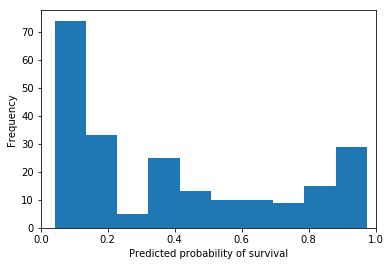

In [31]:
# histogram of predicted probabilities
plt.hist(y_pred_prob)
plt.xlim(0, 1)
plt.xlabel('Predicted probability of survival')
plt.ylabel('Frequency')

In [32]:
# increase sensitivity by lowering the threshold for predicting survival
y_pred_class_new = np.where(y_pred_prob >= 0.3, 1, 0)

In [33]:
y_pred_class_new

array([1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0])

In [34]:
# old confusion matrix
print(confusion)

[[124  15]
 [ 26  58]]


In [35]:
confusion_new = metrics.confusion_matrix(y_test, y_pred_class_new)
print(confusion_new)

[[98 41]
 [12 72]]


In [36]:
TP = confusion_new[1][1]
TN = confusion_new[0][0]
FP = confusion_new[0][1]
FN = confusion_new[1][0]

In [37]:
# new sensitivity (higher than before)
print('Sensitivity:', TP / float(TP + FN))

Sensitivity: 0.8571428571428571


In [38]:
# new specificity (lower than before)
print('Specificity:', TN / float(TN + FP))

Specificity: 0.7050359712230215


In [39]:
print(metrics.classification_report(y_test, y_pred_class_new))

              precision    recall  f1-score   support

           0       0.89      0.71      0.79       139
           1       0.64      0.86      0.73        84

   micro avg       0.76      0.76      0.76       223
   macro avg       0.76      0.78      0.76       223
weighted avg       0.80      0.76      0.77       223



## ROC, auroc

### Drawing ROC curve and calculate AUC

In [41]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [42]:
classifier = LogisticRegression(penalty='l2', C=1)
y_prob = classifier.fit(X_train, y_train).predict_proba(X_test)
y_score = classifier.fit(X_train, y_train).decision_function(X_test)  #로지스틱에선 logit 이 decision function

C:\Users\JunHyuk\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\JunHyuk\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [51]:
print(y_prob[0:5,:])

[[0.30755471 0.69244529]
 [0.88624606 0.11375394]
 [0.54370812 0.45629188]
 [0.60493928 0.39506072]
 [0.89921341 0.10078659]]


In [52]:
print(y_score[0:5])

[ 0.81157623 -2.05295698 -0.17527986 -0.42608861 -2.18851504]


In [53]:
fpr, tpr, _ = roc_curve(y_test, y_prob[:,1])
# fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.8563292223364165


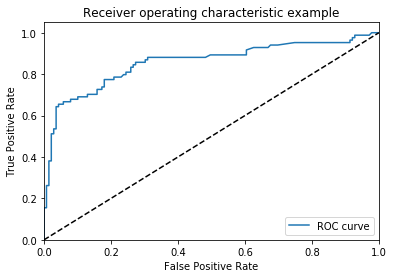

In [54]:
plt.figure()
plt.plot(fpr, tpr, label = 'ROC curve')
plt.plot([0,1], [0,1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [44]:
roc_auc_score(y_test,y_score)   #roc curve 안그리고 바로 auc 계산

0.8563292223364165

In [43]:
?roc_auc_score